In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import sklearn
from sklearn.model_selection import GridSearchCV
import re
from bs4 import BeautifulSoup
import string
import swifter
import numpy as np

In [2]:
df = pd.read_csv('../data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
def preprocess_text(text):
    # remove html strips
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # remove sqaure brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # tokenization
    text = np.array(nltk.word_tokenize(text))

    # lower text
    text = np.char.lower(text) #text = text.lower()


    # remove special characters
    #text = [i for i in text if i.isalnum()]
    text = text[np.char.isalnum(text)]

    # remove stop words & punctuation
    # text = [i for i in text if i not in stopwords.words('english') and i not in string.punctuation]
    mask = np.logical_not(np.logical_and(np.isin(text, stopwords.words('english')), np.isin(text, string.punctuation)))
    text = text[mask]

    # text stemming
    ps = nltk.porter.PorterStemmer()
    text = [ps.stem(i) for i in text]

    return " ".join(text)

In [6]:
df['review'] = df['review'].swifter.apply(lambda x: preprocess_text(x))

Pandas Apply:   0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\ali\AppData\Local\Temp\ipykernel_10392\3916636006.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [7]:
df.loc[df.sentiment == 'positive', 'sentiment'] = 1
df.loc[df.sentiment == 'negative', 'sentiment'] = 0

In [8]:
df.sentiment = df.sentiment.astype(int)

In [9]:
tfidf = TfidfVectorizer(max_features=12000)

In [10]:
X = tfidf.fit_transform(df['review']).toarray()

In [11]:
y = df.sentiment

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [13]:
models = {
    # "SVC": SVC(probability=True, kernel='linear'),
    # "KNN": KNeighborsClassifier(),
    "GNB": GaussianNB(),
    "BNB": BernoulliNB(),
    "MNB": MultinomialNB(),
}

model: GNB
model: BNB
model: MNB


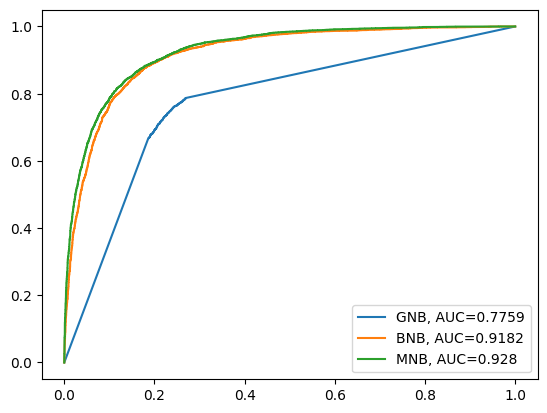

In [14]:
for key, model in models.items():
    print(f'model: {key}')
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=f"{key}, AUC="+str(auc))

plt.legend()

GNB accuracy: 0.7422


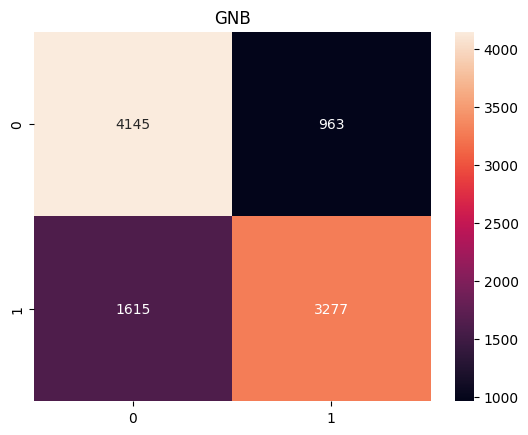

BNB accuracy: 0.8471


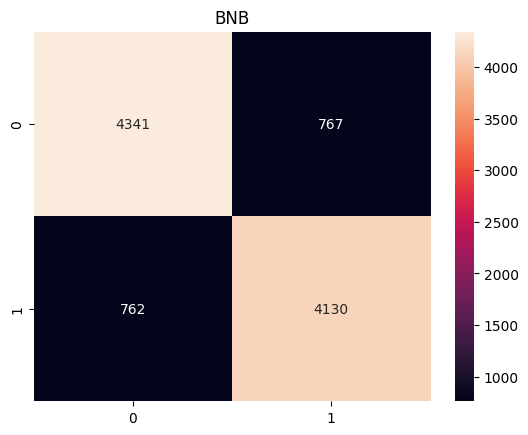

MNB accuracy: 0.8516


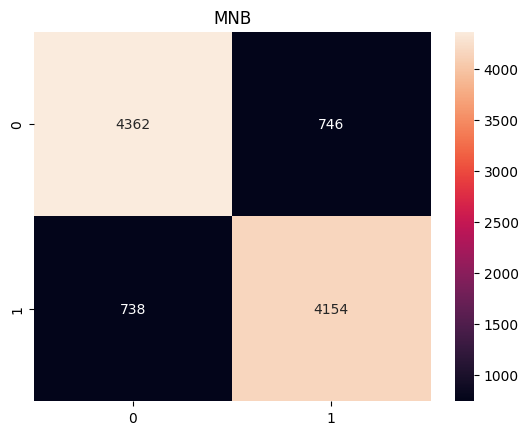

In [15]:
for key, model in models.items():
    y_pred = model.predict(X_test)
    accuracy_score = sklearn.metrics.accuracy_score(y_test, y_pred)
    print(f'{key} accuracy: {accuracy_score}')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f").set(title=key)
    plt.show()

In [16]:
best_model = models['MNB']

In [17]:
import pickle
pickle.dump(best_model, open('../models/nlp_model.pkl', 'wb'))
pickle.dump(tfidf, open('../models/tfidf.pkl', 'wb'))